# Pixelate Club Task 2 COMP9517 20T3

## Computer vision method

In [1]:
# import packages
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def remove_bg(img):
    # Transform from RGB to HSV
    # then uses a mask to remove the background
    # and transform from HSV back to RGB
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    lower = np.array([30,60,75])
    upper = np.array([75,255,255])
    mask = cv2.inRange(img_hsv, lower, upper)
    
    img_green = np.zeros_like(img, np.uint8)
    img_green[mask > 0] = img_hsv[mask > 0]
    
    result = cv2.cvtColor(img_green, cv2.COLOR_HSV2RGB)
    return result

In [3]:
def thresholding(img):
    # Transfrom RGB img to grayscale
    # then determine threshold
    # and apply thresholding
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # use colour histgram to determine threshold
    imgHist = cv2.calcHist([img],[0],None,[256],[1,255])
    max_value = 0
    for i in range(1,256):
        if imgHist[i] > max_value:
            max_value = int(imgHist[i][0])

    # determine threshold via intensity with max amounts of pixel
    threshold = 0
    if max_value > 5000:
        threshold = 100
    else:
        threshold = 70

    # use threshold to convert into black-and-white image
    img[img > threshold] = 255
    img[img < threshold] = 0
    
    return img

In [4]:
def evaluate_cv(img, label):
    # calcuate Dice similarity coefficient and intersection over union
    tp = 0
    fp = 0
    fn = 0
    
    x, y = img.shape
    for i in range(x):
        for j in range(y):
            # positives
            if img[i, j] == 255:            
                if label[i, j] == 255:
                    # true positives
                    tp += 1
                else:
                    # false positives
                    fp += 1
            else:            
                if label[i, j] == 255:
                    # false negatives
                    fn += 1
    
    dsc = 2 * tp / (fp + 2 * tp + fn)
    iou = tp / (fp + tp + fn)
    
    return dsc, iou

In [5]:
def process(img, label):
    img = remove_bg(img)
    img = thresholding(img)
    
    img = cv2.medianBlur(img, 5)
    
    dsc, iou = evaluate_cv(img, label)
    
    return img, dsc, iou

In [6]:
def process_without_median(img, label):
    img = remove_bg(img)
    img = thresholding(img)
    
    dsc, iou = evaluate_cv(img, label)
    
    return img, dsc, iou

### performance on one image

In [7]:
# read image
i = 1
image_name = f'input_data/ara2012_tray{i:02}_rgb.png'
label_name = f'input_data/ara2012_tray{i:02}_fg.png'
img = cv2.imread(image_name)
label = cv2.imread(label_name, 0)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

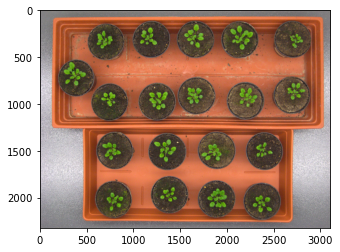

In [8]:
plt.imshow(img)

In [9]:
new_img, dsc, iou = process(img, label)
print('Dice similarity coefficient with median filter applied:', dsc)
print('Intersection over union with median filter applied', iou)

Dice similarity coefficient with median filter applied: 0.9446513095613758
Intersection over union with median filter applied 0.8951082406410716


In [10]:
new_img, dsc, iou = process_without_median(img, label)
print('Dice similarity coefficient without median filter applied:', dsc)
print('Intersection over union without median filter applied', iou)

Dice similarity coefficient without median filter applied: 0.9391004502050296
Intersection over union without median filter applied 0.8851926182705238


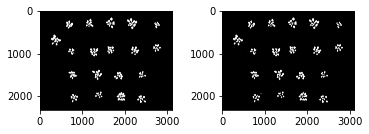

In [22]:
# visualization
plt.subplot(221)
plt.imshow(label, cmap='gray')
plt.subplot(222)
plt.imshow(img, cmap='gray')

### performance on whole dataset

In [11]:
dsc_list_2012 = []
iou_list_2012 = []
dsc_list_2013 = []
iou_list_2013 = []


for k in range(1, 17):
    img = cv2.imread(f'input_data/ara2012_tray{k:02}_rgb.png')
    label = cv2.imread(f'input_data/ara2012_tray{k:02}_fg.png', 0)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img, dsc, iou = process(img, label)
    
    dsc_list_2012.append(dsc)
    iou_list_2012.append(iou)
    
for k in range(1, 28):
    img = cv2.imread(f'input_data/ara2013_tray{k:02}_rgb.png')
    label = cv2.imread(f'input_data/ara2013_tray{k:02}_fg.png', 0)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img, dsc, iou = process(img, label)
    
    dsc_list_2013.append(dsc)
    iou_list_2013.append(iou)

In [14]:
dsc_2012 = np.average(dsc_list_2012)
iou_2012 = np.average(iou_list_2012)

print('Dice similarity coefficient for Ara2012 images:', dsc_2012)
print('Intersection over union for Ara2012 images:', iou_2012)

Dice similarity coefficient for Ara2012 images: 0.9428863110201375
Intersection over union for Ara2012 images: 0.8921679491869652


In [15]:
dsc_2013 = np.average(dsc_list_2013)
iou_2013 = np.average(iou_list_2013)

print('Dice similarity coefficient for Ara2013 images:', dsc_2013)
print('Intersection over union for Ara2013 images:', iou_2013)

Dice similarity coefficient for Ara2013 images: 0.9444117971639311
Intersection over union for Ara2013 images: 0.895159361537652


## Machine Learning Method On One Image

In [11]:
# import packages
from sklearn import svm
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split

In [12]:
def add_data(img, label, X, y):
    # add features to X and label to y
    p, q, r = img.shape
    for i in range(p):
        for j in range(q):
            features = img[i, j, :]
            l = label[i, j]
            X.append(features)
            y.append(l)
    return X, y

In [13]:
def evaluate_ml(y_test, y_pred):
    # calcuate Dice similarity coefficient and intersection over union
    tp = 0
    fp = 0
    fn = 0
    for i in range(len(y_test)):
        if y_pred[i] == 255:
            if y_test[i] == 255:
                # true positives
                tp += 1
            else:
                # false positives
                fp += 1
        else:
            if y_test[i] == 255:
                # false negatives
                fn += 1
    
    dsc = 2 * tp / (fp + 2 * tp + fn)
    iou = tp / (fp + tp + fn)
    
    return dsc, iou

In [14]:
# read image
i = 1
image_name = f'input_data/ara2012_tray{i:02}_rgb.png'
label_name = f'input_data/ara2012_tray{i:02}_fg.png'
img = cv2.imread(image_name)
label = cv2.imread(label_name, 0)

In [15]:
# build dataset
X = []
y = []

X, y = add_data(img, label, X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99)

In [16]:
# train the classifier and predict test set
svm_c = svm.SVC()
svm_c.fit(X_train, y_train)
y_pred = svm_c.predict(X_test)

In [17]:
# performance
dsc, iou = evaluate_ml(y_pred, y_test)
print('Dice similarity coefficient:', dsc)
print('Intersection over union', iou)

Dice similarity coefficient: 0.9809258596457535
Intersection over union 0.962565745515599
